## VARATIONAL AUTOENCODER

Library imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn.functional as F

from torchsummary import summary
from skimage import io, img_as_ubyte
from skimage.transform import resize

import os
import sys
import numpy as np
import matplotlib.pylab as plt

Mounting with google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
zip_path = '/content/drive/My Drive/Thesis/cover.zip'
!cp "{zip_path}" .
!unzip -q cover.zip
!rm cover.zip

Creation of class VAE

In [5]:
class Vae(nn.Module):
    def __init__(self, nc, nef, ndf, batch, latent_space_size):
        #Encoder
        super(Vae, self).__init__()
        self.nc = nc
        self.nef = nef
        self.ndf = ndf
        
        self.conv1 = nn.Conv2d(nc,nef,3,2,1)
        self.bn1 = nn.BatchNorm2d(nef)
        self.conv2 = nn.Conv2d(nef,nef*2,3,2,1)
        self.bn2 = nn.BatchNorm2d(nef*2)   
        self.conv3 = nn.Conv2d(nef*2,nef*2,3,2,1)
        self.bn3 = nn.BatchNorm2d(nef*2)   
        self.conv4 = nn.Conv2d(nef*2,nef*4,3,1,1)
        
        #Decoder        
        self.reconv1 = self.resize_conv(ndf*4,ndf*2,3)
        self.bn4 = nn.BatchNorm2d(ndf*2)
        self.reconv2 = self.resize_conv(ndf*2,ndf*2,3)
        self.bn5 = nn.BatchNorm2d(ndf*2)  
        self.reconv3 = self.resize_conv(ndf*2,ndf,3)
        self.bn6 = nn.BatchNorm2d(ndf)
        self.reconv4 = nn.Conv2d(ndf,nc,3,1,1)

        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        #self.do = nn.Dropout(0)
        
        #Linear
        self.f1 = nn.Linear(nef*4*16*16, latent_space_size)
        self.f2 = nn.Linear(nef*4*16*16, latent_space_size)
        self.d1 = nn.Linear(latent_space_size, nef*4*16*16)
        
        #self.init_weights()
        
    
    def forward (self,x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        x_ = self.decoder(z)   
                 
        return mu, logvar, x_
    

    def encoder(self, x):
        #layer 1
        x = self.conv1(x)
        x = self.bn1(self.leakyrelu(x))
        #layer 2
        x = self.conv2(x)
        x = self.bn2(self.leakyrelu(x))
        #layer 3
        x = self.conv3(x)
        x = self.bn3(self.leakyrelu(x))
        #layer 4
        x = self.leakyrelu(self.conv4(x))
        x = x.view(x.size(0),-1)
        
        return self.f1(x), self.f2(x)
    

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std) #Returns tensor same size as inpufilled with rand nº from Udistribution on interval [0,1)
        return mu+std*eps
        
        
    def decoder(self, x):
        #layer 5
        x = self.d1(x)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.reconv1(x)
        x = self.bn4(self.leakyrelu(x))
        #layer 6
        x = self.reconv2(x)
        x = self.bn5(self.leakyrelu(x))
        #layer 7
        x = self.reconv3(x)
        x = self.bn6(self.leakyrelu(x))
        #Layer 8
        x = self.sigmoid(self.reconv4(x))

        return x                     
        
             
    def resize_conv(self, i, o, k):
        reconv = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                            nn.ReflectionPad2d(1),
                            nn.Conv2d(i, o,
                            kernel_size=k, stride=1, padding=0),)
        return reconv
    

### Download dataset
Dataset download and plotting of the data

In [6]:
dataroot_train = 'cover/train'
dataroot_val = 'cover/val'
dataroot_test = 'cover/test'

train_dataset = datasets.ImageFolder(root=dataroot_train,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

val_dataset = datasets.ImageFolder(root=dataroot_val,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_dataset = datasets.ImageFolder(root=dataroot_test,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

torch.save(train_dataset, 'train_dataset_128_mixed_vae.pt')
torch.save(val_dataset, 'val_dataset_128_mixed_vae.pt')
torch.save(test_dataset, 'test_dataset_128_mixed_vae.pt')
       

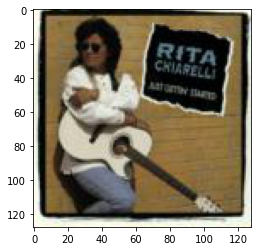

In [7]:

train_dataset = torch.load('train_dataset_128_mixed_vae.pt')
val_dataset = torch.load('val_dataset_128_mixed_vae.pt')
test_dataset = torch.load('test_dataset_128_mixed_vae.pt')

batch = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch, drop_last=True)

# Plot the first image
x, _ = next(iter(train_loader))
x = x[0].permute(1,2,0)
plt.show()
plt.imshow(x)


### Model, criterion and optimizer initilization

In [8]:
# ------------------------------------------ DEFINE MODEL -------------------------------------------------#
torch.manual_seed(42)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

nc = 3
ndf = 32
nef = 32
latent_space_size = 500

model = Vae(nc, ndf, nef, batch, latent_space_size).to(device)
# ------------------------------------------ OPTIMIZER ---------------------------------------------------#
reconst_error = nn.BCELoss()
reconst_error.size_average = False
learning_rate = 1e-4
weight_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [9]:
# Model summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         LeakyReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
         LeakyReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
         LeakyReLU-8           [-1, 64, 16, 16]               0
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 128, 16, 16]          73,856
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Linear-12                  [-1, 500]      16,384,500
           Linear-13                  [-1, 500]      16,384,500
           Linear-14                [-1

In [10]:
# MSE loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean, r,g,b

# VAE loss function
def loss_vae(mu, logvar, x, y):
    bce = F.binary_cross_entropy(x,y,reduction='sum')
    dkl = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    
    return bce, dkl, bce+dkl


### Training

In [ ]:
#### ------------------------------------------------ TRAINING ----------------------------------------------------------#
n_epochs = 50         #Number of epochs training
m = sys.maxsize       #Maximum value to check validation loss
epoch_since_min = 0   #Epochs since not reaching minimum loss in validation set
epoch = 0             #Epoch init
cost_list_train = []  #Training cost list init
cost_list_val = []    #Validation cost list init
lr_list = []          #Learning rate list init

checkpoint = False
if checkpoint:
  checkpoint = torch.load('/content/drive/My Drive/Towards_album_artwork_generation_based_on_audio/models/vae.pth', map_location=lambda storage, loc: storage)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  cost_list_train = checkpoint['cost_list_train']
  cost_list_val = checkpoint['cost_list_val']

  model.to(device)

change_lr = False
if change_lr:
  optimizer.param_groups[0]['lr'] = 3e-5



for epoch in tqdm.tqdm(range(epoch,n_epochs+epoch)):
    COST_TRAIN = 0   
    lr_list.append(lr)
    model.train()
    # ------------------------------------------- TRAINING -----------------------------------------#
    print('TRAINING... Epoch: ',epoch)
    for i, data in enumerate(train_loader):
        img, _ = data        
        img = img.to(device)

        # Forward
        mu, logvar, output = model.forward(img)        
        
        bce_loss, dkl_loss, loss = loss_vae(mu, logvar, output, img)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        COST_TRAIN+=loss.data
        if i % 150 == 0:
            print("Iteration: " + str(i) + '/' + str(len(train_loader)))
            print('Loss: {:.4f}, BCE Loss: {:.4f}, DKL Loss: {:.4f}'
            .format(loss.data.item(), bce_loss.data.item(), dkl_loss.data.item()))

            fig = plt.figure(figsize=(16, 16))
            ax = plt.imshow(np.transpose(vutils.make_grid(output[:32], 
                                                          padding=2, 
                                                          normalize=True, 
                                                          scale_each=True).cpu().detach().numpy(),(1,2,0)))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            plt.show(fig)
        
    #-------------------------------------- EVALUATION --------------------------------------#
    print('EVALUATING...')
    model.eval()
    COST_VAL = 0
    for i, data in enumerate(val_loader):
      img, _ = data
      img = img.to(device)
      mu, logvar, output = model.forward(img)

      bce_loss, dkl_loss, loss = loss_vae(mu, logvar, output, img)
      COST_VAL+=loss.data
      if i % 48 == 0:
        print("Iteration: " + str(i) + '/' + str(len(val_loader)))

    cost_list_train.append(COST_TRAIN/len(train_loader))
    cost_list_val.append(COST_VAL/len(val_loader))
    
    #------------------------- CHECK VAL LOSS METHODOLOGY -----------------------------------#
    print(m)
    if cost_list_val[epoch] < m:
      m = cost_list_val[epoch]
      epoch_since_min = 0
    else:
      epoch_since_min += 1

    print(cost_list_val)
    print(epoch_since_min)

    if epoch_since_min == 5:
      print('Training stopped')
      break

    #Save model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cost_list_train': cost_list_train,
            'cost_list_val': cost_list_val,
            'lr_list': lr_list,
            }, '/content/drive/My Drive/vae_'+str(epoch)+'.pth')
   
    plt.figure()
    plt.plot(cost_list_train, label='training')
    plt.title('TRAIN COST')
    plt.plot(cost_list_val, label='evaluation')
    plt.title('VAL COST')
    plt.legend()
    print(epoch)

### Analysis

Let's first load the trained model

In [22]:
checkpoint = torch.load('/content/drive/My Drive/Towards_album_artwork_generation_based_on_audio/models/vae78.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list_train = checkpoint['cost_list_train']
cost_list_val = checkpoint['cost_list_val']
lr_list = checkpoint['lr_list']

#### Loss graphs
Plot training and validation losses and learning rate used for each epoch during training

Text(0, 0.5, 'Learing rate')

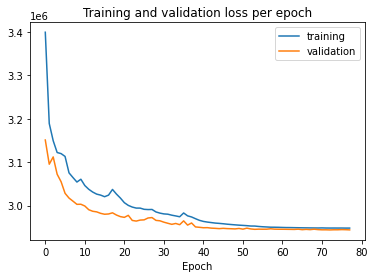

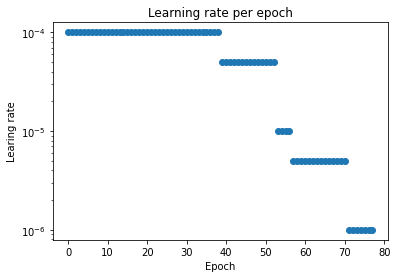

In [23]:
# Plot training and validation losses
plt.figure()
plt.plot(cost_list_train, label='training')
plt.plot(cost_list_val, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and validation loss per epoch')


#Plot learning rate used for each epoch
epoch_list = []
for i in range(len(cost_list_train)):
  epoch_list.append(i)
plt.figure()
plt.scatter(epoch_list, lr_list)
plt.yscale('log')
plt.title('Learning rate per epoch')
plt.xlabel('Epoch')
plt.ylabel('Learing rate')

#### Checking inputs vs outputs
Let's now check the difference between the input images and the outputs

Loss: 3111943.0000, BCE Loss: 3040985.7500, DKL Loss: 70957.1719


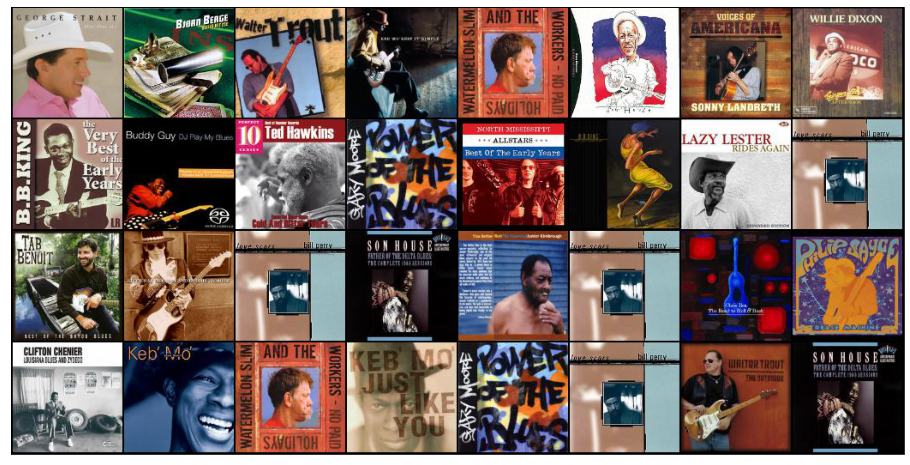

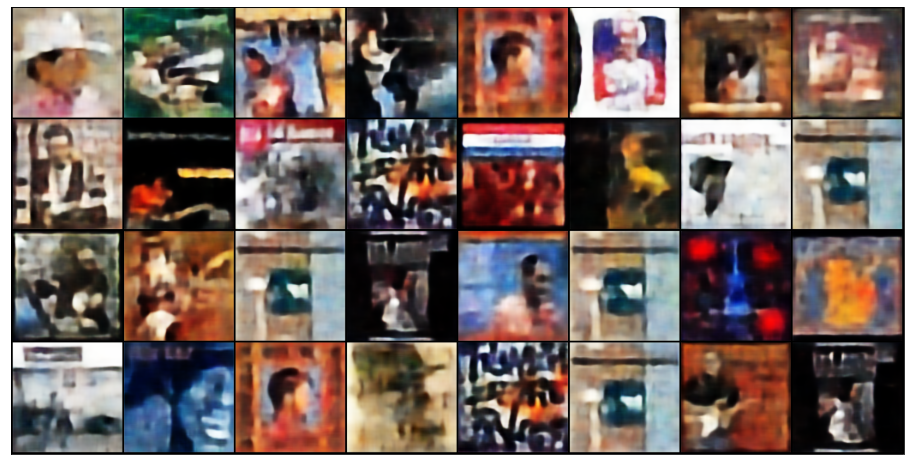

In [ ]:
model.eval()
for i, data in enumerate(test_loader):
    with torch.no_grad():
        img, _ = data        
        img = img.to(device)
        mu, logvar, output = model(img) 

        bce_loss, dkl_loss, loss = loss_vae(mu, logvar, output, img)
        print('Loss: {:.4f}, BCE Loss: {:.4f}, DKL Loss: {:.4f}'.format(loss.data.item(), bce_loss.data.item(), dkl_loss.data.item()))


        #Plot 32 input images
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(img[:32], 
                                                          padding=2, 
                                                          normalize=True, 
                                                          scale_each=True).cpu().detach().numpy(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)

        #Plot 32 output images
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(output[:32], 
                                                          padding=2, 
                                                          normalize=True, 
                                                          scale_each=True).cpu().detach().numpy(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)

        break


#### Image generation
Now, we will try to generate a new image by selecting a random number from the latent space (see that latent space has a size of 500) 

Image max = 1.0, min = 0.0020082530099898577


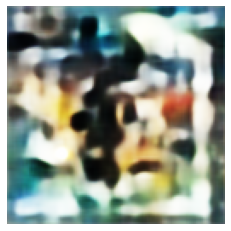

In [ ]:
eps = torch.randn(1, 500).to(device)
mu = torch.randn(1, 500)
std = torch.randn(1, 500)
z = mu[0].view(1,500).to(device)+std[0].view(1,500).to(device)*eps
reconst_img = model.decoder(z.to(device))

img = reconst_img.cpu().squeeze()
img = img.permute(1,2,0)
img = img.detach().numpy()
plt.imshow(img)
plt.axis('off')

#### 2D latent space representation 
We are now going to check how the model is distributing different album artworks by genre in the space by using t-SNE transformation. We will transform the 500 latent space into a 2D latent space

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, drop_last=True)

# Init to store all mu and logvar of train examples
mu_total = np.zeros((train_loader.__len__() ,500))
logvar_total = np.zeros((train_loader.__len__() ,500))

# Set model to evaluation
model.eval()

# Store all mu and logvar from train set
for i, data in enumerate(train_loader):
  data, data_y = data
  mu, logvar = model.encoder(data.to(device))
  mu_total[i] = mu_total[i]+mu.cpu().detach().numpy()
  logvar_total[i] = logvar_total[i]+logvar.cpu().detach().numpy()

In [25]:
from sklearn.manifold import TSNE

m = TSNE(n_components=2, random_state=0)
mu_total = m.fit_transform(mu_total)
logvar_total = m.fit_transform(logvar_total)

We now count the different samples for each of the genres. With the number of samples per genre we can specifically plot the latent space samples for each of the genres

In [26]:
genre_samples = {}
count = 0
last_genre = ''
for root, dirs, files in os.walk('cover/train'):
  for file in files:
    genre = root.replace(os.sep, '/').split('/')[2]
    if genre != last_genre:
      genre_samples[last_genre] = count
      count = 0
    last_genre =  root.replace(os.sep, '/').split('/')[2]
    count+=1

We only plot the 2D latent space samples for: blues, country and electronic for a better visualization

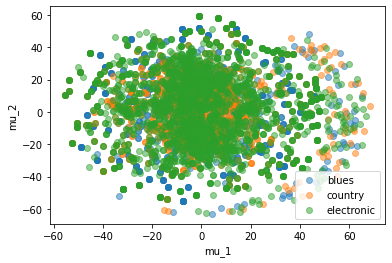

In [27]:
plt.scatter(mu_total[:genre_samples['blues']][:,0], 
            mu_total[:genre_samples['blues']][:,1], 
            label='blues', alpha=0.5)
plt.scatter(mu_total[genre_samples['blues']:genre_samples['country']][:,0], 
            mu_total[genre_samples['blues']:genre_samples['country']][:,1], 
            label='country', alpha=0.5)
plt.scatter(mu_total[genre_samples['country']:genre_samples['electronic']][:,0],
            mu_total[genre_samples['country']:genre_samples['electronic']][:,1],
             label='electronic', alpha=0.5)
plt.xlabel('mu_1')
plt.ylabel('mu_2')
plt.xlabel('mu_1')
plt.ylabel('mu_2')
plt.legend()